In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/미니 프로젝트 2/data/train.csv", sep = ',', index_col = 'index')
test = pd.read_csv("/content/drive/MyDrive/미니 프로젝트 2/data/test.csv", sep = ',', index_col = 'index')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5497 entries, 0 to 5496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quality               5497 non-null   int64  
 1   fixed acidity         5497 non-null   float64
 2   volatile acidity      5497 non-null   float64
 3   citric acid           5497 non-null   float64
 4   residual sugar        5497 non-null   float64
 5   chlorides             5497 non-null   float64
 6   free sulfur dioxide   5497 non-null   float64
 7   total sulfur dioxide  5497 non-null   float64
 8   density               5497 non-null   float64
 9   pH                    5497 non-null   float64
 10  sulphates             5497 non-null   float64
 11  alcohol               5497 non-null   float64
 12  type                  5497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 601.2+ KB


# EDA (Exploratory Data Analysis)

- quality: 품질
- fixed acidity: 산도
- volatile acidity: 휘발성산
- citric acid: 시트르산
- residual sugar 잔당 (발효 후 와인 속에 남아있는 당분)
- chlorides: 염화물
- free sulfur dioxide: 독립 이산화황
- total sulfur dioxide: 총 이산화황
- density: 밀도
- pH: 수소이온농도
- sulphates: 황산염
- alcohol: 도수
- type: 종류

In [ ]:
train.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
index,,,,,,,,,,,,,
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [ ]:
train['type'].value_counts()

,count
type,
white,4159
red,1338


In [ ]:
# Encoding type feature
train['type_encoded'] = 0
train.loc[train.type=='red', 'type_encoded'] = 1
train.drop('type', axis=1, inplace=True)

train.type_encoded.value_counts()

,count
type_encoded,
0,4159
1,1338


<Axes: >

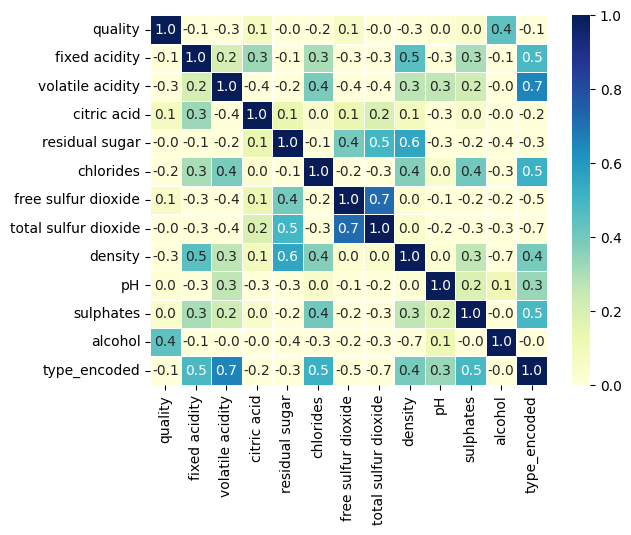

In [ ]:
# (quality, alchohol), (fixed acidity, density), (fixed acidity, type) etc have strong correlations with each other.
import seaborn as sns
sns.heatmap(train.corr(), vmin=0, vmax=1, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=0.5)

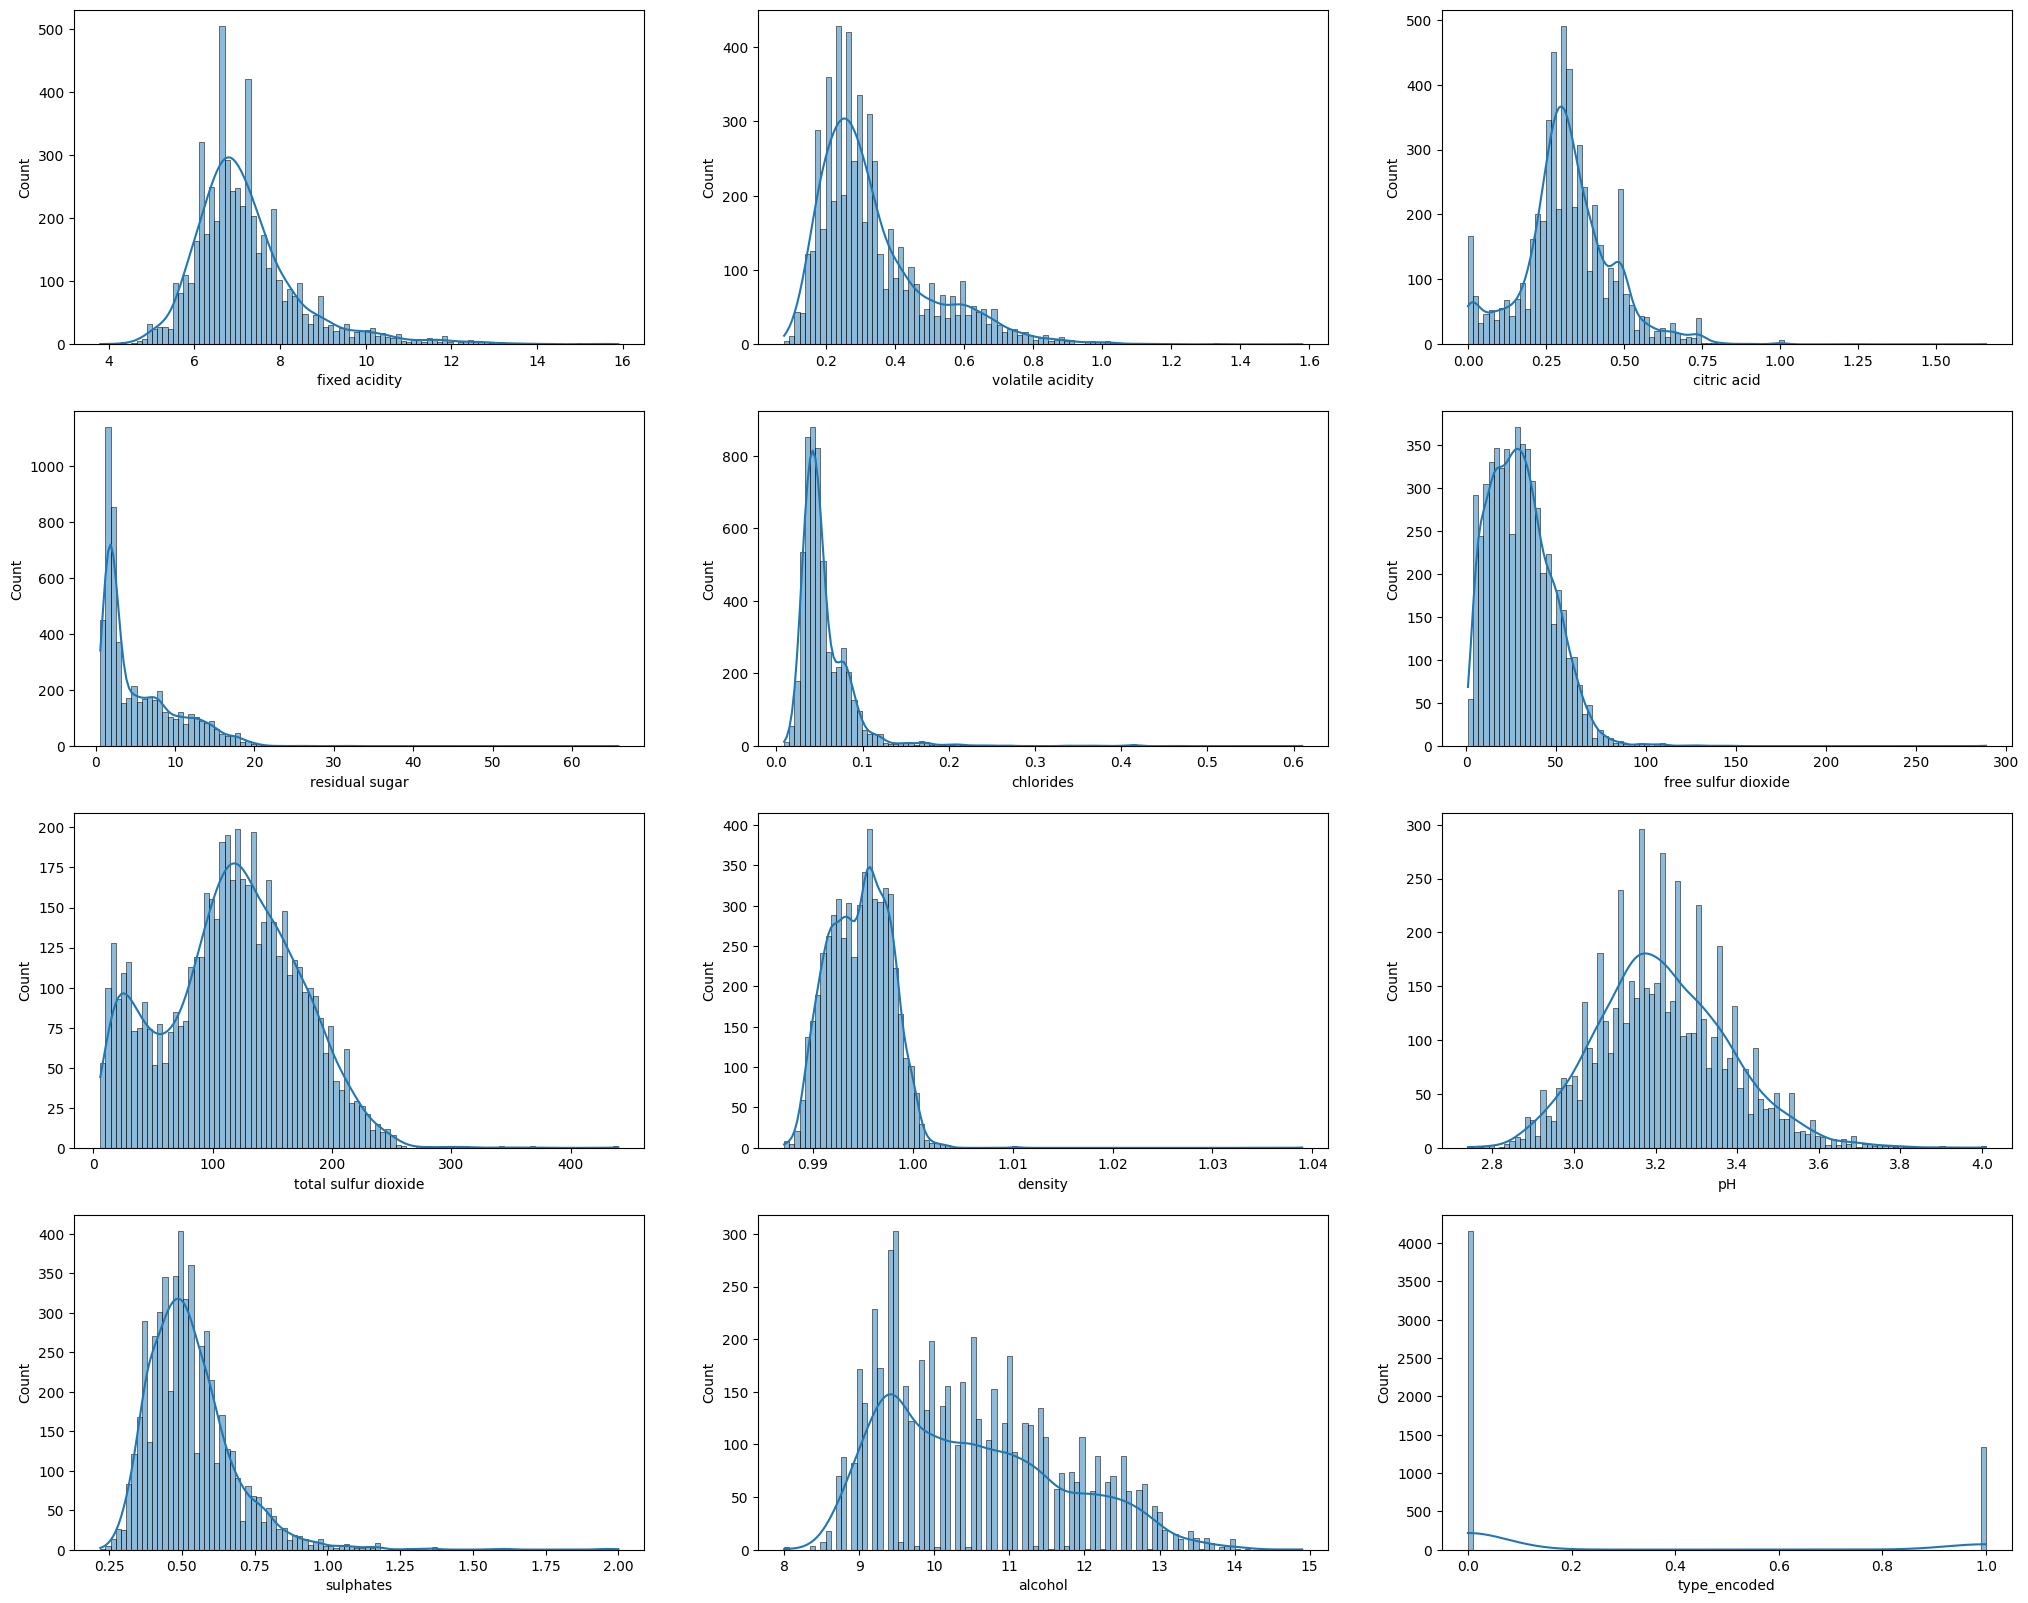

In [ ]:
# 피처별로 분포도 확인
f, ax = plt.subplots(4, 3, figsize=(25, 20))
sns.histplot(train.iloc[:,1], bins=100, kde=True, ax=ax[0,0])
sns.histplot(train.iloc[:,2], bins=100, kde=True, ax=ax[0,1])
sns.histplot(train.iloc[:,3], bins=100, kde=True, ax=ax[0,2])
sns.histplot(train.iloc[:,4], bins=100, kde=True, ax=ax[1,0])
sns.histplot(train.iloc[:,5], bins=100, kde=True, ax=ax[1,1])
sns.histplot(train.iloc[:,6], bins=100, kde=True, ax=ax[1,2])
sns.histplot(train.iloc[:,7], bins=100, kde=True, ax=ax[2,0])
sns.histplot(train.iloc[:,8], bins=100, kde=True, ax=ax[2,1])
sns.histplot(train.iloc[:,9], bins=100, kde=True, ax=ax[2,2])
sns.histplot(train.iloc[:,10], bins=100, kde=True, ax=ax[3,0])
sns.histplot(train.iloc[:,11], bins=100, kde=True, ax=ax[3,1])
sns.histplot(train.iloc[:,12], bins=100, kde=True, ax=ax[3,2])

plt.show()

In [ ]:
# 피처별 왜도(치우침 정도) 측정
from scipy.stats import skew

skewness = pd.DataFrame(skew(train.iloc[:,1:]), index=train.columns[1:], columns=['Skewness for each feature'])
skewness

,Skewness for each feature
fixed acidity,1.710430
volatile acidity,1.497435
citric acid,0.492351
residual sugar,1.498545
chlorides,5.185911
free sulfur dioxide,1.310273
total sulfur dioxide,0.002600
density,0.603954
pH,0.387750
sulphates,1.914956


# Feature Engineering & Modeling

**Evaluation 함수 생성**

In [ ]:
# get_clf_eval() 함수를 이용해 평가 수행
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro', zero_division=0)
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    y_test_onehot = label_binarize(y_test, classes=train['quality'].unique())
    pred_onehot = label_binarize(pred, classes=train['quality'].unique())
    roc_auc = roc_auc_score(y_test_onehot, pred_onehot, average='macro', multi_class='ovr')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)
  kfold = KFold(n_splits=10, random_state=22, shuffle=True)
  cv_result = cross_val_score(model, ftr_train, tgt_train, cv=kfold, scoring='accuracy')
  print('Cross validated score is:', cv_result.mean())

**Basic Algorithm**

In [ ]:
# Basic Algorithm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = train.iloc[:, 1:]
y = train['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   6   1   0   0   0]
 [  0   4  25  12   0   0   0]
 [  0   2 259  83   2   0   0]
 [  0   0  85 403  27   0   0]
 [  0   0   3  67  90   1   0]
 [  0   0   2  13   5   9   0]
 [  0   0   0   0   1   0   0]]
정확도: 0.6955, 정밀도: 0.5235, 재현율: 0.3569, F1: 0.3873, AUC:0.6426
Cross validated score is: 0.6520552909505073
None


Cross validated score for RandomForest is: 0.6520552909505073
Model variance of RandomForest is: 0.026422559931482105


<Axes: >

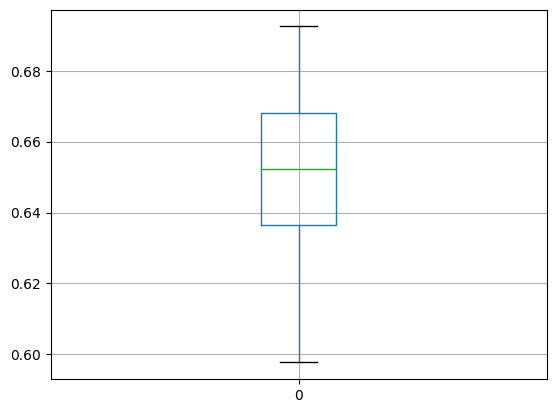

In [ ]:
# KFold Cross Validation
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kfold = KFold(n_splits=10, random_state=22, shuffle=True)
accuracy=[]
cv_result = cross_val_score(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy')
print('Cross validated score for RandomForest is:', cv_result.mean())
print('Model variance of RandomForest is:', cv_result.std())

accuracy.append(cv_result)
pd.DataFrame(accuracy).T.boxplot()

In [ ]:
print(X.info(), y.info())
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 5497 entries, 0 to 5496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5497 non-null   float64
 1   volatile acidity      5497 non-null   float64
 2   citric acid           5497 non-null   float64
 3   residual sugar        5497 non-null   float64
 4   chlorides             5497 non-null   float64
 5   free sulfur dioxide   5497 non-null   float64
 6   total sulfur dioxide  5497 non-null   float64
 7   density               5497 non-null   float64
 8   pH                    5497 non-null   float64
 9   sulphates             5497 non-null   float64
 10  alcohol               5497 non-null   float64
 11  type_encoded          5497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 687.3 KB
<class 'pandas.core.series.Series'>
Index: 5497 entries, 0 to 5496
Series name: quality
Non-Null Count  Dtype
--------------  -----

**정규분포로 변환 - skewness값이 큰 chlorides**

In [ ]:
# 정규분포로 변환 (skewness값이 큰 chlorides)
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df_standard(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    chlorides_scaled = scaler.fit_transform(df_copy['chlorides'].values.reshape(-1, 1))
    df_copy.insert(1, 'chlorides_scaled', chlorides_scaled)
    df_copy.drop(['chlorides'], axis=1, inplace=True)
    return df_copy

In [ ]:
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df_standard(df)
  X = df_copy.iloc[:, 1:]
  y = df_copy['quality']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df=train)

In [ ]:
# Evaluation
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   6   1   0   0   0]
 [  0   4  26  11   0   0   0]
 [  0   2 256  87   1   0   0]
 [  0   0  81 406  28   0   0]
 [  0   0   1  78  81   1   0]
 [  0   0   2  13   5   9   0]
 [  0   0   0   0   1   0   0]]
정확도: 0.6873, 정밀도: 0.5192, 재현율: 0.3485, F1: 0.3801, AUC:0.6372
Cross validated score is: 0.6556875129426383
None


**로그변환 - skewness값이 큰 chlorides**

In [ ]:
# 로그변환 (skewness값이 큰 chlorides)
def get_preprocessed_df_log(df=None):
    df_copy = df.copy()
    chlorides_log = np.log1p(df_copy['chlorides'])
    df_copy.insert(1, 'chlorides_log', chlorides_log)
    df_copy.drop(['chlorides'], axis=1, inplace=True)
    return df_copy

In [ ]:
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df_log(df)
  X = df_copy.iloc[:, 1:]
  y = df_copy['quality']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df=train)

In [ ]:
# Evaluation
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   6   1   0   0   0]
 [  0   4  26  11   0   0   0]
 [  0   2 256  87   1   0   0]
 [  0   0  81 405  29   0   0]
 [  0   0   1  79  80   1   0]
 [  0   0   2  13   5   9   0]
 [  0   0   0   0   1   0   0]]
정확도: 0.6855, 정밀도: 0.5177, 재현율: 0.3473, F1: 0.3788, AUC:0.6364
Cross validated score is: 0.6550041416442328
None


**이상치 제거 - quality와 상관관계가 높은 volatile acidity, density, alcohol (heatmap 참고)**

In [ ]:
# 이상치 제거(quality와 상관관계가 높은 volatile acidity, density, alcohol. heatmap 참고.)
import numpy as np
def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [ ]:
outlier_index_of_volatile_acidity = get_outlier(df=train, column='volatile acidity', weight=1.5)
print('volatile acidity의 이상치 데이터 인덱스:', outlier_index_of_volatile_acidity)

outlier_index_of_density = get_outlier(df=train, column='density', weight=1.5)
print('density의 이상치 데이터 인덱스:', outlier_index_of_density)

outlier_index_of_alcohol = get_outlier(df=train, column='alcohol', weight=1.5)
print('alcohol의 이상치 데이터 인덱스:', outlier_index_of_alcohol)

volatile acidity의 이상치 데이터 인덱스: Index([   0,   23,   24,   36,   37,   41,   69,   84,   90,   98,
       ...
       5304, 5325, 5350, 5354, 5364, 5419, 5439, 5446, 5452, 5481],
      dtype='int64', name='index', length=314)
density의 이상치 데이터 인덱스: Index([1220, 4068, 4189], dtype='int64', name='index')
alcohol의 이상치 데이터 인덱스: Index([2787, 4964, 5340], dtype='int64', name='index')


In [ ]:
def get_preprocessed_df_outlier(df=None):
    df_copy = df.copy()
    outlier_index_of_volatile_acidity = get_outlier(df=df_copy, column='volatile acidity', weight=1.5)
    outlier_index_of_density = get_outlier(df=df_copy, column='density', weight=1.5)
    outlier_index_of_alcohol = get_outlier(df=df_copy, column='alcohol', weight=1.5)
    outlier = np.unique(np.concatenate((outlier_index_of_volatile_acidity, outlier_index_of_density, outlier_index_of_alcohol)))
    df_copy.drop(outlier, axis=0, inplace=True)
    return df_copy

from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df_outlier(df)
  X = df_copy.iloc[:, 1:]
  y = df_copy['quality']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df=train)

In [ ]:
# Evaluation
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   1   1   0   0   0]
 [  0   3  17   5   0   0   0]
 [  0   1 227  85   5   0   0]
 [  0   0  68 388  38   0   0]
 [  0   0   6  77  84   1   0]
 [  0   0   0  12   6  10   0]
 [  0   0   0   0   1   0   0]]
정확도: 0.6873, 정밀도: 0.5258, 재현율: 0.3538, F1: 0.3885, AUC:0.6398
Cross validated score is: 0.6653739596065422
None


**HyperParameter Tuning**

In [ ]:
# HyperParameter Tuning Using Baeysian Estimator
from hyperopt import hp, STATUS_OK

rf_search_space = {'n_estimators' : hp.quniform('n_estimators', 100, 1000, 100),
                   'max_depth' :  hp.quniform('max_depth', 5, 20, 1),
                   'min_samples_leaf' : hp.quniform('min_samples_leaf', 1, 12, 1),
                   'min_samples_split' : hp.quniform('min_samples_split', 2, 16, 1)
}

def objective_func(search_space):
  rf_clf = RandomForestClassifier(n_estimators=int(search_space['n_estimators']),
                                  max_depth=int(search_space['max_depth']),
                                  min_samples_leaf=int(search_space['min_samples_leaf']),
                                  min_samples_split=int(search_space['min_samples_split']))

  accuracy = cross_val_score(rf_clf, X_train, y_train, scoring='accuracy', cv=3)

  # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
  return {'loss':-1 * np.mean(accuracy), 'status':STATUS_OK}

# fmin()으로 최적 하이퍼 파라미터 도출
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=rf_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정
            trials=trial_val,
            rstate=np.random.default_rng(seed=9))

print('n_estimators:{0}, max_depth:{1}, min_samples_leaf:{2}, min_samples_split:{3}'.format(round(best['n_estimators']), round(best['max_depth']), round(best['min_samples_leaf']), round(best['min_samples_split'])))

100%|██████████| 50/50 [12:56<00:00, 15.52s/trial, best loss: -0.6337552078414088]
n_estimators:900, max_depth:20, min_samples_leaf:2, min_samples_split:4


In [ ]:
# HyperParameter Tuning Using GridSearchCV (Takes too long)
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : range(100, 1000, 100),
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
    }

grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('RandomForest의 최적 파라미터:', grid_cv.best_params_)
print('RandomForest의 best score:', grid_cv.best_score_)

In [263]:
# Evaluation
rf_clf = RandomForestClassifier(n_estimators=900, max_depth=20, min_samples_leaf=2, min_samples_split=4)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   1   0   1   0   0]
 [  0   1  16   8   0   0   0]
 [  0   0 228  88   2   0   0]
 [  0   0  63 398  33   0   0]
 [  0   0   5  80  83   0   0]
 [  0   0   0  13   7   8   0]
 [  0   0   0   1   0   0   0]]
정확도: 0.6931, 정밀도: 0.5806, 재현율: 0.3346, F1: 0.3635, AUC:0.6303
Cross validated score is: 0.6632017926779583
None


**최적의 모델**

In [264]:
def get_preprocessed_df(df=None):
  df_copy = get_preprocessed_df_standard(df)
  df_copy = get_preprocessed_df_outlier(df_copy)
  return df_copy

In [265]:
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X = df_copy.iloc[:, 1:]
  y = df_copy['quality']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df=train)

In [266]:
# Evaluation
rf_clf = RandomForestClassifier(n_estimators=900, max_depth=20, min_samples_leaf=2, min_samples_split=4, random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(get_model_train_eval(rf_clf, X_train, X_test, y_train, y_test))

오차 행렬
[[  0   0   1   0   1   0   0]
 [  0   1  16   8   0   0   0]
 [  0   0 226  88   4   0   0]
 [  0   0  62 401  31   0   0]
 [  0   0   5  78  85   0   0]
 [  0   0   0  13   7   8   0]
 [  0   0   0   1   0   0   0]]
정확도: 0.6959, 정밀도: 0.5820, 재현율: 0.3363, F1: 0.3651, AUC:0.6315
Cross validated score is: 0.6651329957511205
None
